# Modelando el comportamiento de los arriendos de bicicletas en Seúl según la temperatura ambiental. 


### Importando Librerias

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn import datasets
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import statsmodels as sms
import statsmodels.formula as smf


In [2]:
from pandas_profiling import ProfileReport


### Importando y leyendo base de Datos SeoulBikeData

In [3]:
# Leer el dataset con datos imputados

bikedata = pd.read_excel("SeoulBikeData_DatosImputados.xlsx")

In [4]:
bikedata.head()

Date  Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  \
0 2017-12-01              254.0     0              -52           37   
1 2017-12-01              204.0     1              -55           38   
2 2017-12-01              173.0     2               -6           39   
3 2017-12-01              107.0     3              -62           40   
4 2017-12-01               78.0     4               -6           36   

   Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
0                22              2000                       -176   
1                 8              2000                       -176   
2                 1              2000                       -177   
3                 9              2000                       -176   
4                23              2000                       -186   

   Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm) Seasons     Holiday  \
0                        0             0              0  Winter  No Holiday   
1                        0             0              0  Winter  No Holiday   
2                        0             0              0  Winter  No Holiday   
3                        0             0              0  Winter  No Holiday   
4                        0             0              0  Winter  No Holiday   

  Functioning Day  
0             Yes  
1             Yes  
2             Yes  
3             Yes  
4             Yes

In [5]:
#Información General del Dataset

bikedata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       8760 non-null   datetime64[ns]
 1   Rented Bike Count          8760 non-null   float64       
 2   Hour                       8760 non-null   int64         
 3   Temperature(°C)            8760 non-null   int64         
 4   Humidity(%)                8760 non-null   int64         
 5   Wind speed (m/s)           8760 non-null   int64         
 6   Visibility (10m)           8760 non-null   int64         
 7   Dew point temperature(°C)  8760 non-null   int64         
 8   Solar Radiation (MJ/m2)    8760 non-null   int64         
 9   Rainfall(mm)               8760 non-null   int64         
 10  Snowfall (cm)              8760 non-null   int64         
 11  Seasons                    8760 non-null   object        
 12  Holida

In [6]:
#Renombrando Variables para su evaluación y Proceso

bikedata=bikedata.rename({'Rented Bike Count': 'Rented_Bike_Count','Temperature(°C)': 'Temperature' ,'Humidity(%)':'Humidity', 'Wind speed (m/s)': 'wind_speed', 
                 'Visibility (10m)':'Visibility', 'Dew point temperature(°C)':'Dew_point_temperature', 
                 'Solar Radiation (MJ/m2)':'Solar_radiation', 'Rainfall(mm)':'Rainfall', 'Snowfall (cm)': 'Snowfall',
                 'Functioning Day': 'Functioning_Day' },axis=1)

In [7]:
#Buscando Valores Nulos
bikedata.isnull().sum()

Date                     0
Rented_Bike_Count        0
Hour                     0
Temperature              0
Humidity                 0
wind_speed               0
Visibility               0
Dew_point_temperature    0
Solar_radiation          0
Rainfall                 0
Snowfall                 0
Seasons                  0
Holiday                  0
Functioning_Day          0
dtype: int64

In [8]:
#Evaluando datos Duplicados

bikedata.duplicated().sum()

0

Data de variables iniciales y descripsción
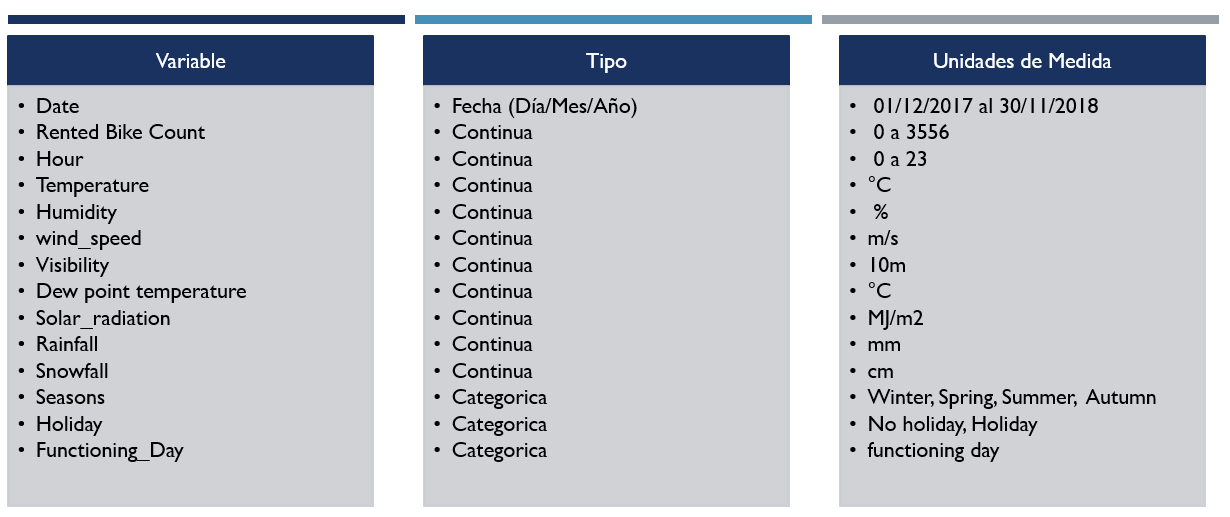

### Cambiando Fecha a formato 'Datetime' y creando variables de día, mes, año para evaluación de los arriendos de bicicletas

In [14]:
#trasformar fecha a formato 'Datetime'

bikedata['Date']=pd.to_datetime(bikedata['Date'],infer_datetime_format= True)
bikedata['Month']=bikedata.Date.dt.month_name().str[:3]
bikedata['Year']= bikedata.Date.dt.year
bikedata['Weekday']= bikedata.Date.dt.weekday
bikedata.Weekday= bikedata.Weekday.map({0:'Monday', 1:'Tuesday',2:'Wednesday', 3:'Thursday', 4:'Fryday', 5: 'Saturday', 6:'Sunday'})
bikedata['Weekday']= pd.Categorical(bikedata['Weekday'],
                     categories= ['Monday','Tuesday','Wednesday','Thursday', 'Fryday','Saturday', 'Sunday'] , ordered=True)
bikedata.head()

Date  Rented_Bike_Count  Hour  Temperature  Humidity  wind_speed  \
0 2017-12-01              254.0     0          -52        37          22   
1 2017-12-01              204.0     1          -55        38           8   
2 2017-12-01              173.0     2           -6        39           1   
3 2017-12-01              107.0     3          -62        40           9   
4 2017-12-01               78.0     4           -6        36          23   

   Visibility  Dew_point_temperature  Solar_radiation  Rainfall  Snowfall  \
0        2000                   -176                0         0         0   
1        2000                   -176                0         0         0   
2        2000                   -177                0         0         0   
3        2000                   -176                0         0         0   
4        2000                   -186                0         0         0   

  Seasons     Holiday Functioning_Day Month  Year Weekday  
0  Winter  No Holiday             Yes   Dec  2017  Fryday  
1  Winter  No Holiday             Yes   Dec  2017  Fryday  
2  Winter  No Holiday             Yes   Dec  2017  Fryday  
3  Winter  No Holiday             Yes   Dec  2017  Fryday  
4  Winter  No Holiday             Yes   Dec  2017  Fryday

### Visualizando las variables del Dataset

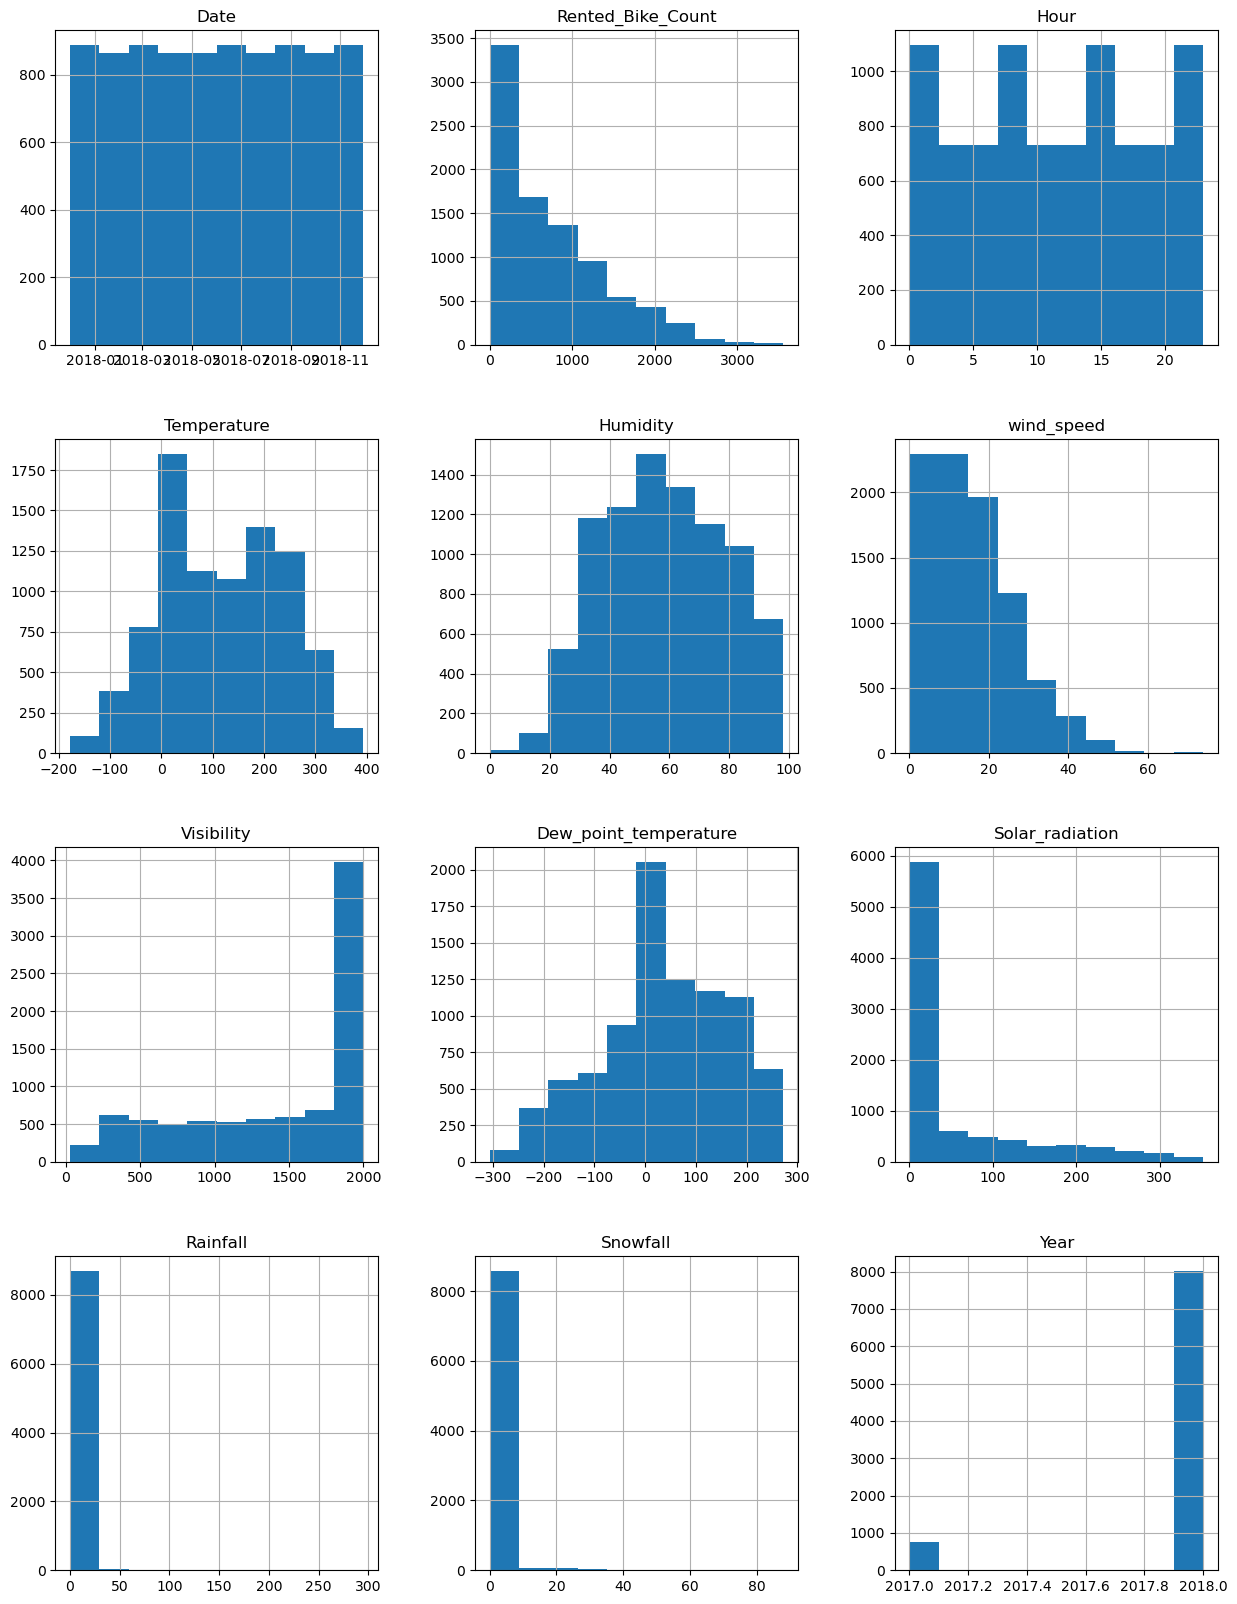

<Figure size 640x480 with 0 Axes>

In [15]:
#visualizando datos de manera independiente 

bikedata.hist(figsize=(15, 20))
plt.show()
plt.tight_layout()

In [16]:
#Evaluación de Esatdísticos de las variables

bikedata.describe().transpose()

count         mean         std     min      25%  \
Rented_Bike_Count      8760.0   736.804623  642.278158     2.0   218.00   
Hour                   8760.0    11.500000    6.922582     0.0     5.75   
Temperature            8760.0   117.488813  118.879484  -178.0    18.00   
Humidity               8760.0    58.226256   20.362413     0.0    42.00   
wind_speed             8760.0    15.646347   10.878694     0.0     7.00   
Visibility             8760.0  1436.825799  608.298712    27.0   940.00   
Dew_point_temperature  8760.0    36.808333  124.048701  -306.0   -34.00   
Solar_radiation        8760.0    52.008333   84.138884     0.0     0.00   
Rainfall               8760.0     0.886872    7.859516     0.0     0.00   
Snowfall               8760.0     0.609932    3.882392     0.0     0.00   
Year                   8760.0  2017.915068    0.278796  2017.0  2018.00   

                          50%      75%     max  
Rented_Bike_Count       556.0  1096.00  3556.0  
Hour                     11.5    17.25    23.0  
Temperature             115.0   217.00   394.0  
Humidity                 57.0    74.00    98.0  
wind_speed               14.0    23.00    74.0  
Visibility             1698.0  2000.00  2000.0  
Dew_point_temperature    28.0   137.00   272.0  
Solar_radiation           1.0    78.00   352.0  
Rainfall                  0.0     0.00   295.0  
Snowfall                  0.0     0.00    88.0  
Year                   2018.0  2018.00  2018.0

## Graficos de arriendos en distintas medidas de tiempo

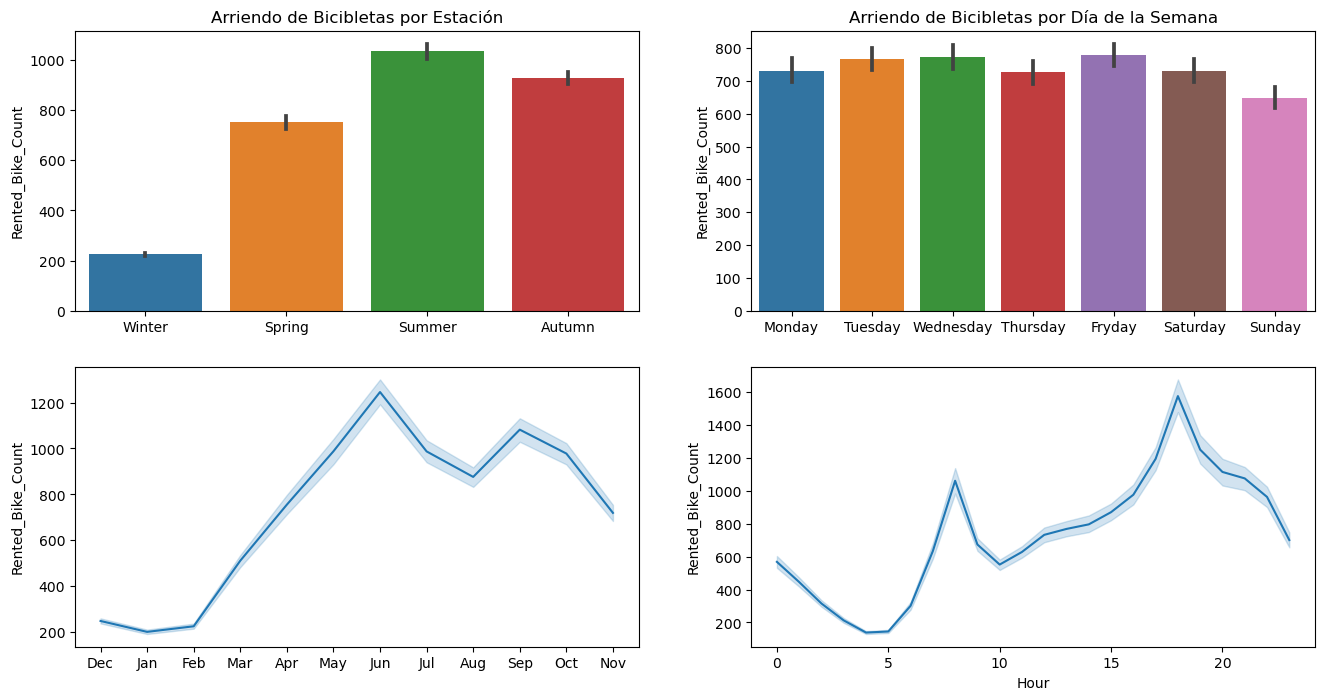

In [18]:
fig, ((ax1,ax2),(ax3,ax4))= plt.subplots(2,2,figsize=(16,8))
sns.barplot(data=bikedata, x= 'Seasons', y= 'Rented_Bike_Count', ax=ax1)
sns.lineplot(data= bikedata, x= 'Month', y= 'Rented_Bike_Count', ax=ax3, )
sns.barplot(data=bikedata, x= 'Weekday', y= 'Rented_Bike_Count', ax=ax2,)
sns.lineplot(data= bikedata, x= 'Hour', y= 'Rented_Bike_Count', ax=ax4, )
ax1.set_title('Arriendo de Bicibletas por Estación')
ax1.set_xlabel("")
ax3.set_xlabel("")
ax2.set_title('Arriendo de Bicibletas por Día de la Semana')
ax2.set_xlabel("")

plt.savefig('Linea de Tiempo.png',dpi=300)
plt.show()

### Visualizacion de Arriendo de bicicletas por horas en relación a vacaciones y estaciones del año

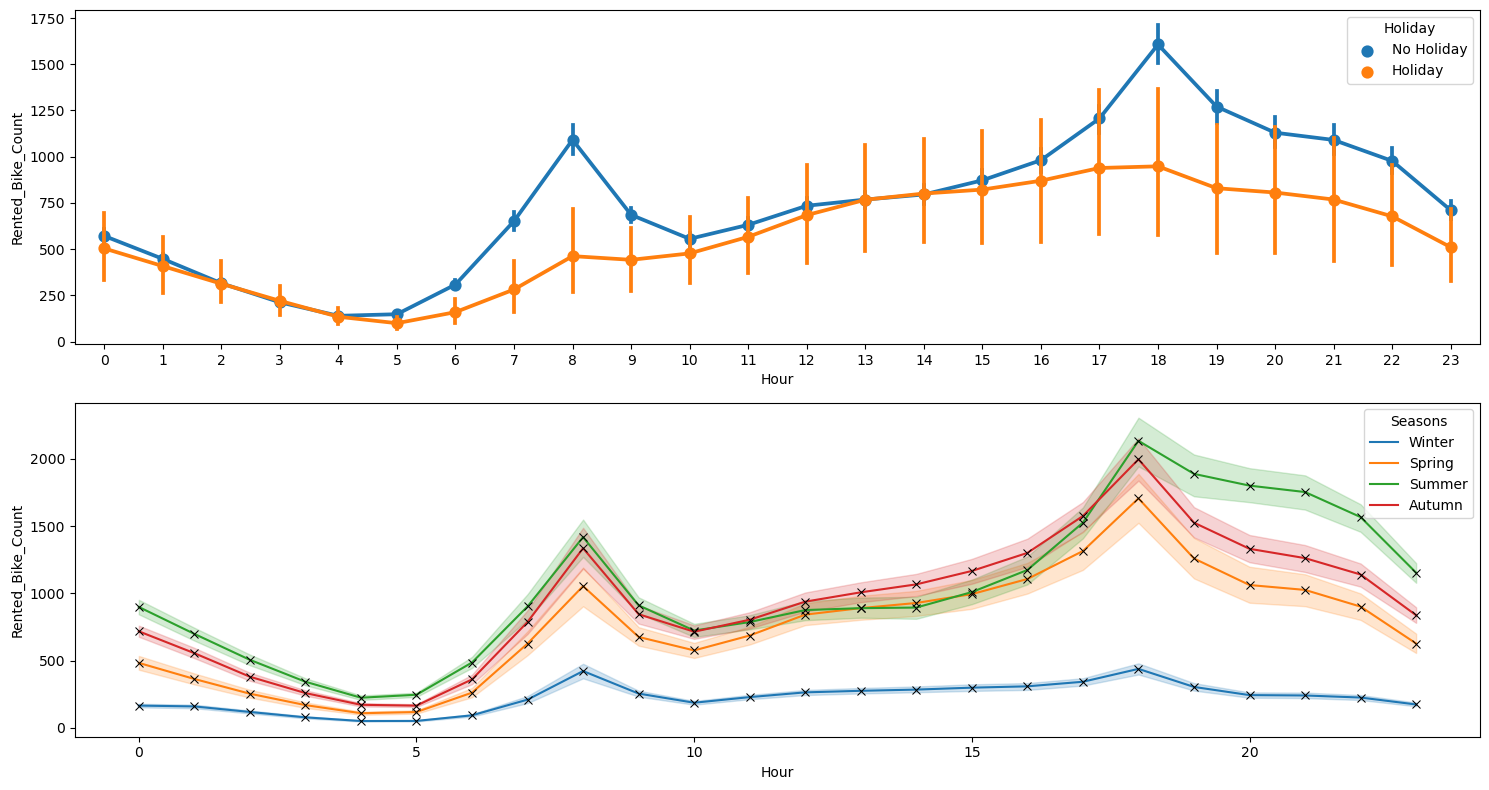

In [19]:
fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(15,8), dpi=100)
sns.pointplot(data=bikedata, x="Hour", y="Rented_Bike_Count", ax=axs[0], 
              hue="Holiday")
sns.lineplot(data=bikedata, x="Hour", y="Rented_Bike_Count", ax=axs[1], 
              hue="Seasons", marker="x",markeredgecolor="black")
plt.tight_layout()


### VISUALIZACIÓN DE LAS VARIABLES DE MANERA INDIVIDUAL

#### Arriendo de Bicicletas por hora

<AxesSubplot:xlabel='Hour', ylabel='Rented_Bike_Count'>

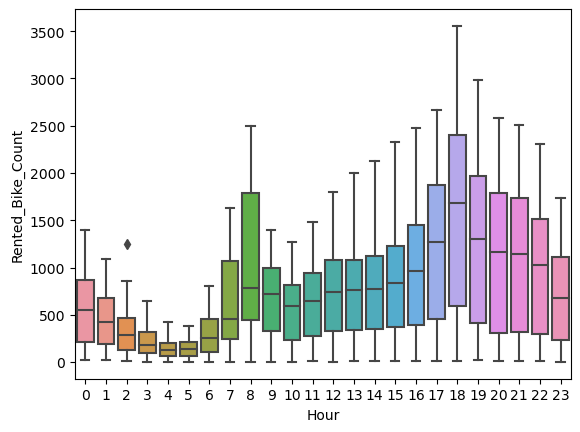

In [20]:
sns.boxplot(data=bikedata, x="Hour", y="Rented_Bike_Count")

In [21]:
# AGRUOANDO POR HORA Y CALCULANDO EL TOTAL DE ARRIENDOS DE BICICLETAS
Hora= bikedata.groupby('Hour').sum()['Rented_Bike_Count'].sort_values(ascending = False).reset_index()
Hora.head()

Hour  Rented_Bike_Count
0    18           574691.5
1    19           455958.0
2    17           435651.0
3    20           406594.0
4    21           392274.5

#### Arriendo de Bicicleta por Día de la Semana

<AxesSubplot:xlabel='Weekday', ylabel='Rented_Bike_Count'>

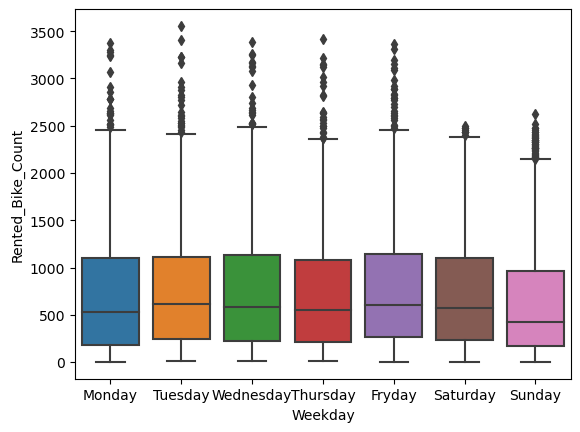

In [22]:
sns.boxplot(data=bikedata, x="Weekday", y="Rented_Bike_Count")

In [23]:
# AGRUOANDO POR DIA DE LA SEMANA Y CALCULANDO EL TOTAL DE ARRIENDOS DE BICICLETAS
Dia= bikedata.groupby('Weekday').sum()['Rented_Bike_Count'].sort_values(ascending = False).reset_index()
Dia

Weekday  Rented_Bike_Count
0     Fryday           991549.0
1  Wednesday           965954.5
2    Tuesday           956895.5
3     Monday           911743.0
4   Saturday           911188.0
5   Thursday           907206.5
6     Sunday           809872.0

#### Arriendo de Bicicletas por Día Funcional

<AxesSubplot:xlabel='Functioning_Day', ylabel='Rented_Bike_Count'>

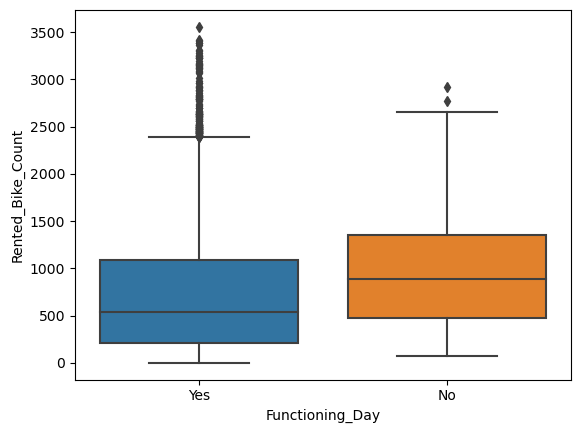

In [24]:
sns.boxplot(data=bikedata, x='Functioning_Day', y="Rented_Bike_Count")

#### Aqui aparecen datos en días No Funcionales, estos valores corresponden a los valores imputados.

In [25]:
# AGRUOANDO POR DIA DE LA SEMANA Y CALCULANDO EL TOTAL DE ARRIENDOS DE BICICLETAS
dia_fun= bikedata.groupby('Functioning_Day').sum()['Rented_Bike_Count'].sort_values(ascending = False).reset_index()
dia_fun.head()


Functioning_Day  Rented_Bike_Count
0             Yes          6172314.0
1              No           282094.5

#### Arriendo de Biciletas v/s Vacaciones (Hollidays)

<AxesSubplot:xlabel='Holiday', ylabel='Rented_Bike_Count'>

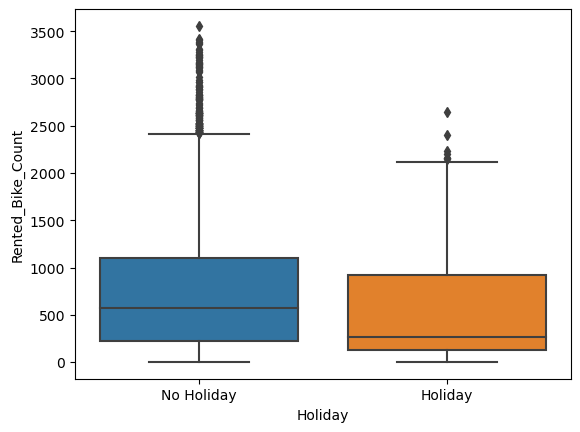

In [26]:
sns.boxplot(data=bikedata, x='Holiday', y="Rented_Bike_Count")

In [27]:
# AGRUOANDO POR HOLIDAY Y CALCULANDO EL TOTAL DE ARRIENDOS DE BICICLETAS
Holiday= bikedata.groupby('Holiday').sum()['Rented_Bike_Count'].sort_values(ascending = False).reset_index()
Holiday

Holiday  Rented_Bike_Count
0  No Holiday          6211627.5
1     Holiday           242781.0

#### Arriendo de Bicicletas por mes

<AxesSubplot:xlabel='Month', ylabel='Rented_Bike_Count'>

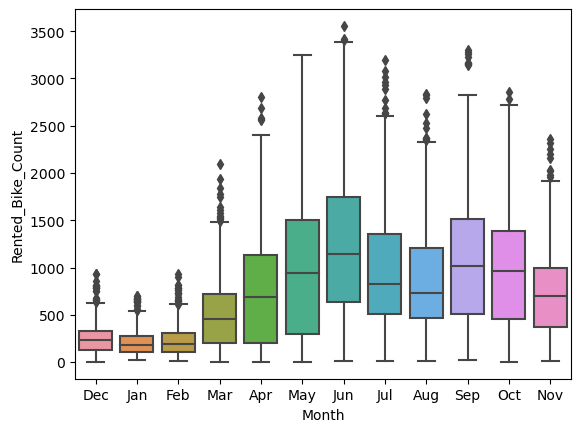

In [28]:
sns.boxplot(data=bikedata, x="Month", y="Rented_Bike_Count")

In [29]:
# GROUPING POR MES AND CALCULATING THE TOTAL RENTED BIKE COUNT
Month= bikedata.groupby('Month').sum()['Rented_Bike_Count'].sort_values(ascending = False).reset_index()
Month.head()


Month  Rented_Bike_Count
0   Jun           896887.0
1   Sep           778980.0
2   May           734860.0
3   Jul           734460.0
4   Oct           727547.5

#### Arriendo de Bicicletas por Estación del Año

<AxesSubplot:xlabel='Seasons', ylabel='Rented_Bike_Count'>

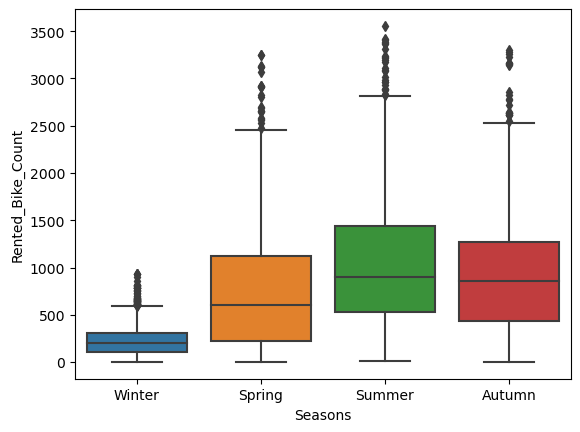

In [30]:
sns.boxplot(data=bikedata, x="Seasons", y="Rented_Bike_Count")

In [31]:
# AGRUOANDO POR ESTACION Y CALCULANDO EL TOTAL DE ARRIENDOS DE BICICLETAS
Season= bikedata.groupby('Seasons').sum()['Rented_Bike_Count'].sort_values(ascending = False).reset_index()
Season

Seasons  Rented_Bike_Count
0  Summer          2283234.0
1  Autumn          2024612.0
2  Spring          1659393.5
3  Winter           487169.0

### Correlacion de las variables del Dataset y el Arriendo de Bicicletas

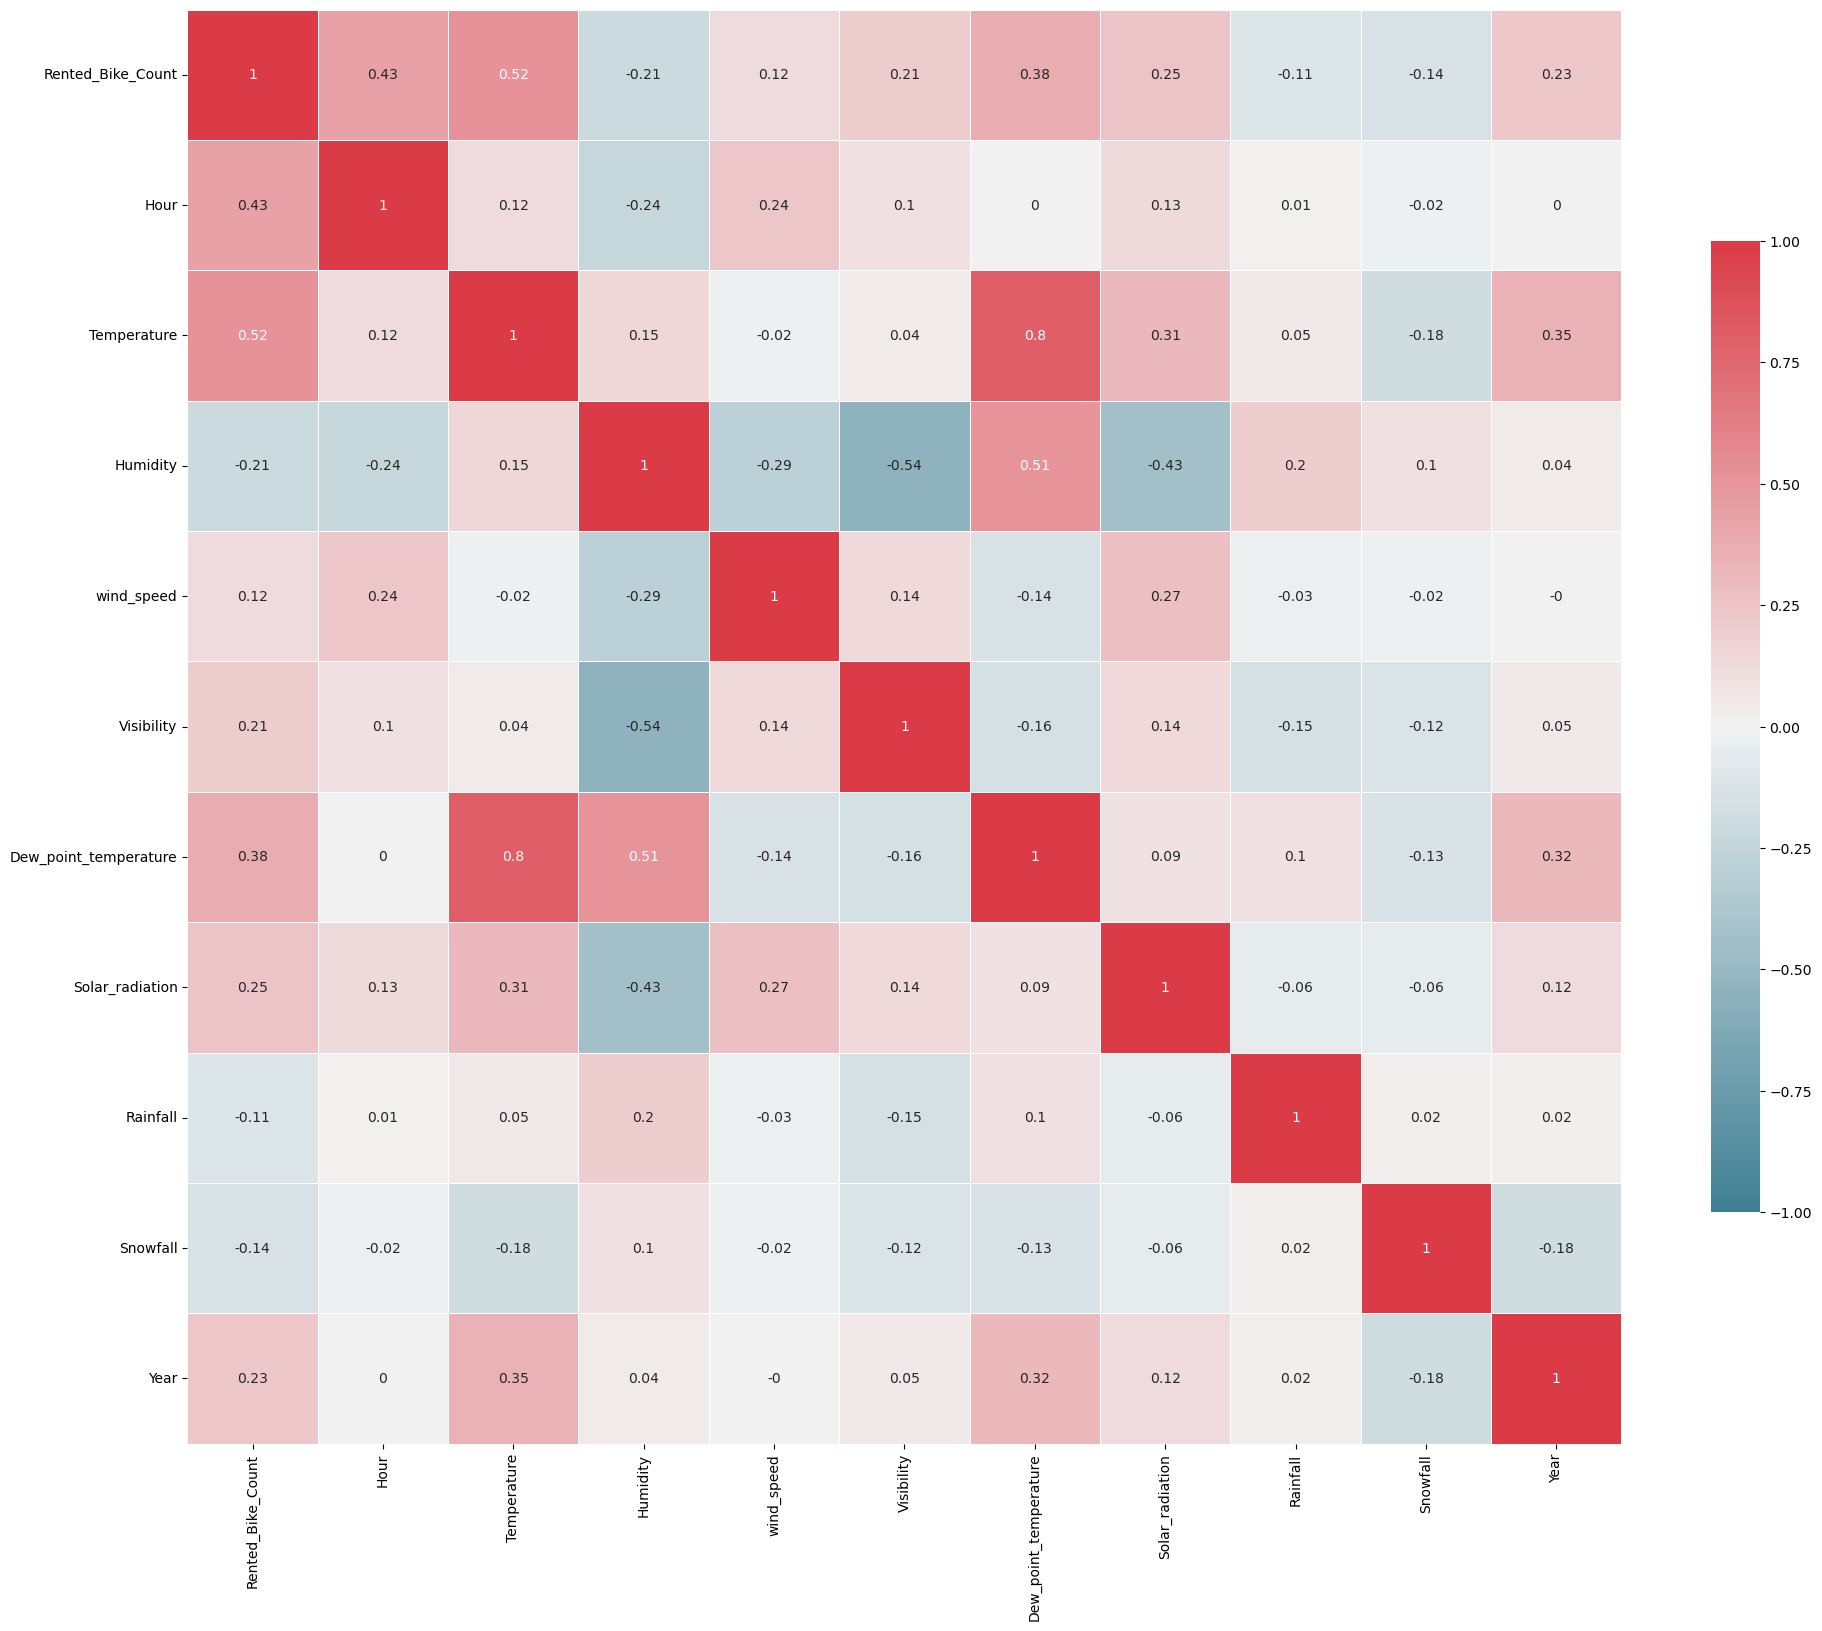

In [32]:
# Generando matriz de correlacion de datos
corr = bikedata.corr().round(2)
# Visualizando la matriz de correlacion
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.tight_layout()

<function matplotlib.pyplot.show(close=None, block=None)>

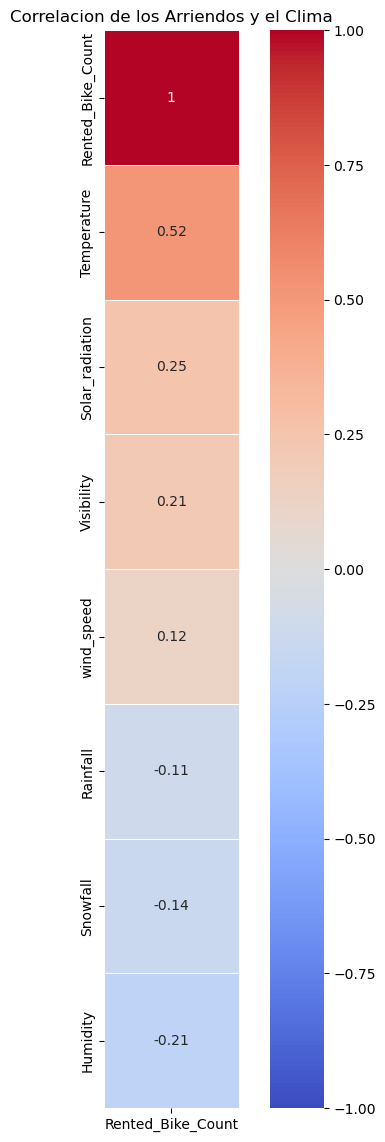

In [33]:
# Visualizando la correlacion de las variables del clima y el arriendo de Bicicletas

f, ax = plt.subplots(figsize=(8, 14))

corr= bikedata[['Temperature', 'wind_speed','Humidity','Solar_radiation','Rainfall','Visibility','Snowfall','Rented_Bike_Count']].corr()
sns.heatmap(data=corr[['Rented_Bike_Count']].sort_values(by= 'Rented_Bike_Count', ascending= False), vmin=-1, vmax=1, center=0,
            cmap='coolwarm', annot= True, square=True, linewidths = .5)
plt.title('Correlacion de los Arriendos y el Clima')
plt.savefig('Correlacion.png',dpi=300)
plt.show


### Eliminando las variables que no aportan al modelo

##### Se elimina la variable Functioning_Day, ya que todos los datos corresponden a 'Yes', por lo cual no es últil como predictor y la variable 'Dew_point_temperature'  que está correlacionada en un 0.91 a la variable Temperature.


In [34]:
bikedata_final= bikedata.drop(columns=['Functioning_Day','Dew_point_temperature' ], axis=1)
bikedata_final.head()

Date  Rented_Bike_Count  Hour  Temperature  Humidity  wind_speed  \
0 2017-12-01              254.0     0          -52        37          22   
1 2017-12-01              204.0     1          -55        38           8   
2 2017-12-01              173.0     2           -6        39           1   
3 2017-12-01              107.0     3          -62        40           9   
4 2017-12-01               78.0     4           -6        36          23   

   Visibility  Solar_radiation  Rainfall  Snowfall Seasons     Holiday Month  \
0        2000                0         0         0  Winter  No Holiday   Dec   
1        2000                0         0         0  Winter  No Holiday   Dec   
2        2000                0         0         0  Winter  No Holiday   Dec   
3        2000                0         0         0  Winter  No Holiday   Dec   
4        2000                0         0         0  Winter  No Holiday   Dec   

   Year Weekday  
0  2017  Fryday  
1  2017  Fryday  
2  2017  Fryday  
3  2017  Fryday  
4  2017  Fryday

### Graficando las Variables del dataset Modificado

<AxesSubplot:xlabel='Date', ylabel='Rented_Bike_Count'>

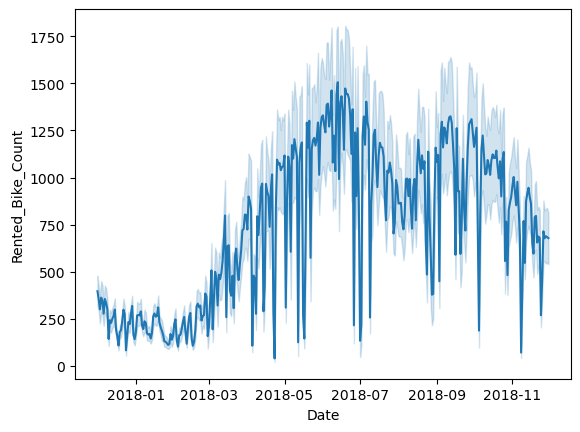

In [35]:
sns.lineplot(x='Date', y="Rented_Bike_Count",data= bikedata_final)

In [36]:
# AGRUOANDO POR FECHA Y CALCULANDO EL TOTAL DE ARRIENDOS DE BICICLETAS
Fecha= bikedata_final.groupby('Date').sum()['Rented_Bike_Count'].sort_values(ascending = True).reset_index()
Fecha

Date  Rented_Bike_Count
0   2018-04-23              977.0
1   2018-11-08             1721.0
2   2017-12-24             2014.0
3   2018-02-04             2487.0
4   2018-02-16             2593.0
..         ...                ...
360 2018-06-21            34621.0
361 2018-06-20            34639.0
362 2018-06-08            35103.0
363 2018-06-19            35349.0
364 2018-06-13            36149.0

[365 rows x 2 columns]

In [37]:
Zeros= bikedata[bikedata_final['Rented_Bike_Count']==0]
print(Zeros.shape)
print(bikedata_final.shape)
print(f'Existen 295 valores 0 en la Rented_Bike_Count')

(0, 17)
(8760, 15)
Existen 295 valores 0 en la Rented_Bike_Count


Se obaserva un cambio en el grafico al imputar los datos y ahora no existen valores Zero

<AxesSubplot:xlabel='Temperature', ylabel='Rented_Bike_Count'>

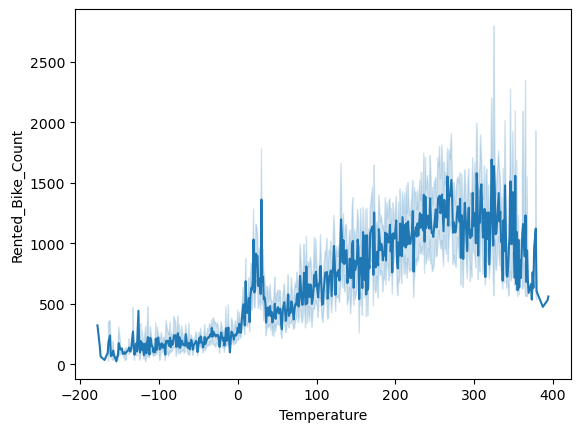

In [38]:
sns.lineplot(x="Temperature", y="Rented_Bike_Count",data= bikedata)

In [39]:
# AGRUOANDO POR TEMPERATURA Y CALCULANDO EL TOTAL DE ARRIENDOS DE BICICLETAS
Temperatura= bikedata.groupby('Temperature').sum()['Rented_Bike_Count'].sort_values(ascending = False).reset_index()
Temperatura.head()

Temperature  Rented_Bike_Count
0           25            50956.0
1          234            46013.5
2          242            43476.0
3           24            43006.5
4          191            40306.5

<AxesSubplot:xlabel='Humidity', ylabel='Rented_Bike_Count'>

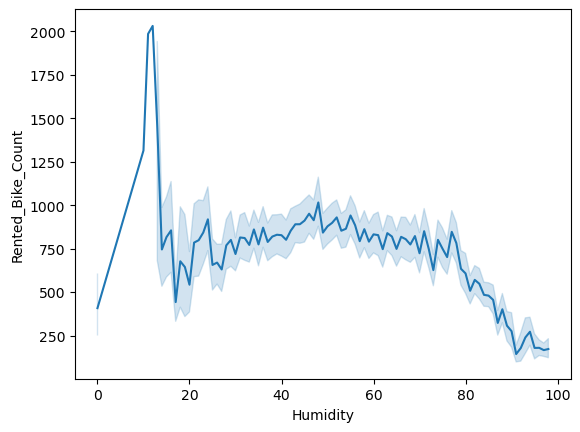

In [40]:
sns.lineplot(x='Humidity', y="Rented_Bike_Count",data= bikedata)

In [41]:
# AGRUOANDO POR HUMEDAD Y CALCULANDO EL TOTAL DE ARRIENDOS DE BICICLETAS
Humedad= bikedata.groupby('Humidity').sum()['Rented_Bike_Count'].sort_values(ascending = False).reset_index()
Humedad.head()

Humidity  Rented_Bike_Count
0        53           147615.5
1        43           146006.5
2        47           142538.0
3        52           139488.5
4        51           139276.0

<AxesSubplot:xlabel='wind_speed', ylabel='Rented_Bike_Count'>

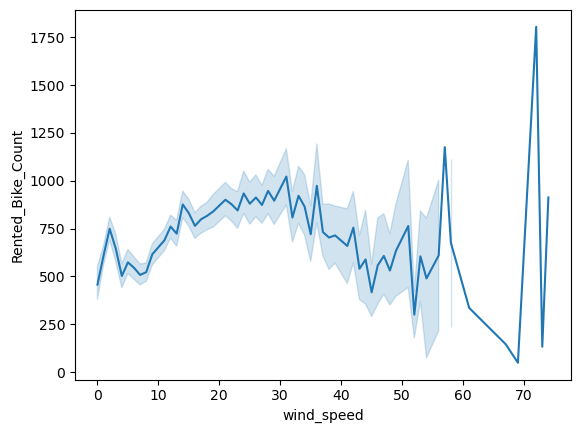

In [42]:
sns.lineplot(x='wind_speed', y="Rented_Bike_Count",data= bikedata)

In [43]:
# AGRUOANDO POR VELOCIDAD DEL VIENTO Y CALCULANDO EL TOTAL DE ARRIENDOS DE BICICLETAS
Viento= bikedata.groupby('wind_speed').sum()['Rented_Bike_Count'].sort_values(ascending = False).reset_index()
Viento.head()

wind_speed  Rented_Bike_Count
0          14           311136.0
1          12           306618.0
2          11           289559.0
3          15           284865.0
4           2           275048.0

<AxesSubplot:xlabel='Visibility', ylabel='Rented_Bike_Count'>

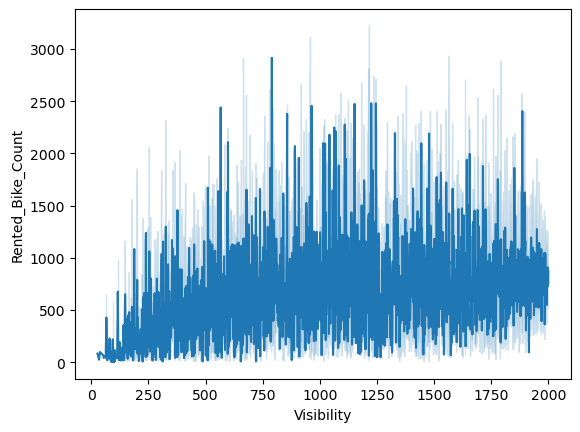

In [44]:
sns.lineplot(x='Visibility', y="Rented_Bike_Count",data= bikedata)

In [45]:
# AGRUOANDO POR VISIBILIDAD Y CALCULANDO EL TOTAL DE ARRIENDOS DE BICICLETAS
Visibilidad= bikedata.groupby('Visibility').sum()['Rented_Bike_Count'].sort_values(ascending = False).reset_index()
Visibilidad.head()

Visibility  Rented_Bike_Count
0        2000          1949678.5
1        1995            29343.0
2        1987            23851.0
3        1989            23372.0
4        1992            22647.0

<AxesSubplot:xlabel='Rainfall', ylabel='Rented_Bike_Count'>

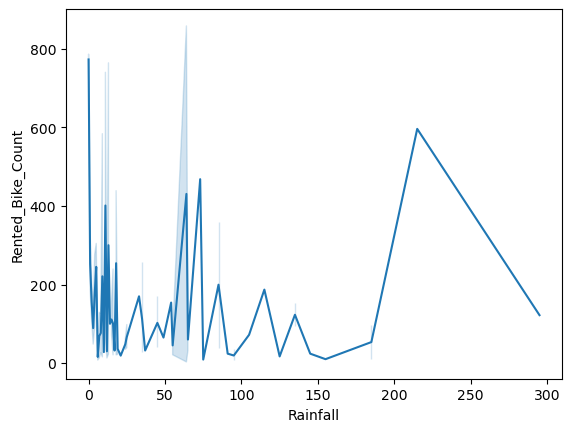

In [46]:
sns.lineplot(x='Rainfall', y="Rented_Bike_Count",data= bikedata)

In [47]:
# AGRUOANDO POR LLUVIA Y CALCULANDO EL TOTAL DE ARRIENDOS DE BICICLETAS
Lluvia= bikedata.groupby('Rainfall').sum()['Rented_Bike_Count'].sort_values(ascending = False).reset_index()
Lluvia.head()

Rainfall  Rented_Bike_Count
0         0          6360641.0
1         5            29629.0
2         1            28259.5
3         2             7972.5
4        15             6212.5

<AxesSubplot:xlabel='Snowfall', ylabel='Rented_Bike_Count'>

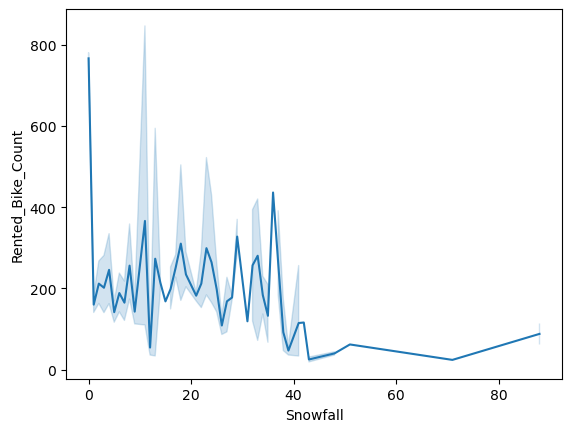

In [48]:
sns.lineplot(x='Snowfall', y="Rented_Bike_Count",data= bikedata)

In [49]:
# AGRUOANDO POR NIEVE Y CALCULANDO EL TOTAL DE ARRIENDOS DE BICICLETAS
Nieve= bikedata.groupby('Snowfall').sum()['Rented_Bike_Count'].sort_values(ascending = False).reset_index()
Nieve.head()

Snowfall  Rented_Bike_Count
0         0          6372408.5
1         3             9473.0
2         2             7834.0
3         1             6562.0
4         4             6141.0

In [50]:
%%time
profile = ProfileReport(bikedata_final,
                        explorative=True,
                       )
profile

CPU times: total: 46.9 ms
Wall time: 48.5 ms


Summarize dataset:   0%|          | 0/29 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Aparecen 7 advertencias de los datos procesados:

La correlación que conocemos entre las variables Month, Year y Month Season, ya que correspoden a la temporalidad y le hemos separado para poder evaluar mejor el arriendo de las bicicletas

Valores Zero de variable Hour, que corresponde a la hora 00:00 (365)

Valores Zero de variable Solar_Radiation (4300), no sabemos si no se midieron

Valores Zero de variable RainFall (8232), los días sin lluvia 0mm

Valores Zero de variable Snowfall (8317), los días sin nieve 0 cc

Se decide trabajar con estos datos en el analisis